In [1]:
# python libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import liana as li
import decoupler as dc

import session_info

In [2]:
# Setting up R dependencies
import anndata2ri
import rpy2
from rpy2.robjects import r
import random

anndata2ri.activate()

%load_ext rpy2.ipython

/tmp/ipykernel_1158414/2969930097.py:7: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.


In [3]:
%%R
suppressPackageStartupMessages({
    library(reticulate)
    library(ggplot2)
    library(tidyr)
    library(dplyr)
    library(purrr)
    library(tibble)
})


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [4]:
# figure settings
# sc.settings.set_figure_params(dpi=200, frameon=False)
# sc.set_figure_params(dpi=200, facecolor="white")
# sc.set_figure_params(figsize=(5, 5))

# Case Study

As a simple example, we will look at ~25k PBMCs from 8 lupus patients, each before and after IFN-β stimulation [Kang et al., 2018]. Note that by focusing on PBMCs, for the purpose of this tutorial, we assume that coordinated events occur among them.

In [4]:
# Read in
adata = sc.read(
    "kang_counts_25k.h5ad", 
    # backup_url="https://figshare.com/ndownloader/files/34464122"
)
adata

# Store the counts for later use
adata.layers["counts"] = adata.X.copy()

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [6]:
# Store the counts for later use
adata.layers["counts"] = adata.X.copy()
# Rename label to condition, replicate to patient
adata.obs = adata.obs.rename({"label": "condition", "replicate": "patient"}, axis=1)
# assign sample
adata.obs["sample"] = (
    adata.obs["condition"].astype("str") + "&" + adata.obs["patient"].astype("str")
)

In [7]:
adata.obs

,nCount_RNA,nFeature_RNA,tsne1,tsne2,condition,cluster,cell_type,patient,nCount_SCT,nFeature_SCT,integrated_snn_res.0.4,seurat_clusters,n_genes,sample
index,,,,,,,,,,,,,,
AAACATACATTTCC-1,3017.0,877,-27.640373,14.966629,ctrl,9,CD14+ Monocytes,patient_1016,1704.0,711,1,1,877,ctrl&patient_1016
AAACATACCAGAAA-1,2481.0,713,-27.493646,28.924885,ctrl,9,CD14+ Monocytes,patient_1256,1614.0,662,1,1,713,ctrl&patient_1256
AAACATACCATGCA-1,703.0,337,-10.468194,-5.984389,ctrl,3,CD4 T cells,patient_1488,908.0,337,6,6,337,ctrl&patient_1488
AAACATACCTCGCT-1,3420.0,850,-24.367997,20.429285,ctrl,9,CD14+ Monocytes,patient_1256,1738.0,653,1,1,850,ctrl&patient_1256
AAACATACCTGGTA-1,3158.0,1111,27.952170,24.159738,ctrl,4,Dendritic cells,patient_1039,1857.0,928,12,12,1111,ctrl&patient_1039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCATGCCTGAA-2,1033.0,468,18.268321,1.058202,stim,6,CD4 T cells,patient_1244,1128.0,468,2,2,468,stim&patient_1244
TTTGCATGCCTGTC-2,2116.0,819,-11.563067,2.574095,stim,4,B cells,patient_1256,1669.0,799,3,3,819,stim&patient_1256
TTTGCATGCTAAGC-2,1522.0,523,25.142392,6.603815,stim,6,CD4 T cells,patient_107,1422.0,523,0,0,523,stim&patient_107


In [8]:
# log1p normalize the data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In this case study, we will assume that cell types such as B cells and CD4 T cells carry out a signal mediator role, while others, such as CD8 T cells and Natural Killer cells, are composed of the cells that carry out the response. In other words, we will treat B and CD4 T cells as the sources of CCC signalling, while the latter are the receivers of CCC stimuli. This is of course an oversimplification as signalling sources and receivers are expected to be dynamic and multi-directional, thus the cell types that we treat as which category depends on the hypothesis in mind.

In [9]:
adata.obs["cell_type"].cat.categories

Index(['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'NK cells', 'CD8 T cells',
       'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes'],
      dtype='object')

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


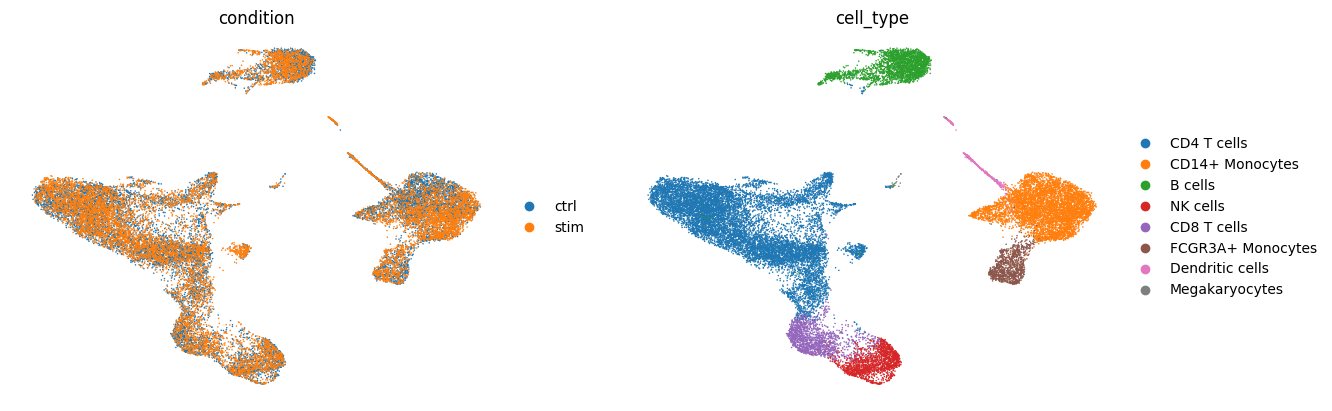

In [10]:
sc.pl.umap(adata, color=["condition", "cell_type"], frameon=False)

# Ligand-receptor inference

First, let’s use the CellPhoneDB (v2) ligand-receptor method [Efremova et al., 2020].

We will run CellPhoneDB on the data post IFN-beta stimulation alone, as such methods were initially designed for the inference of CCC events in “steady-state” data, or in other words, they are meant to be used not across samples or conditions, but rather on a single condition or sample at a time. Note that, nevertheless, certain approaches exist to apply ligand-receptor methods across conditions but these are out of scope for this tutorial, and instead we refer to them in the Outlook section.

In [11]:
adata_stim = adata[adata.obs["condition"] == "stim"].copy()
adata_stim

AnnData object with n_obs × n_vars = 12301 × 15701
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'patient', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes', 'sample'
    var: 'name', 'n_cells'
    uns: 'log1p', 'condition_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [12]:
# import cellphonedb method via liana
from liana.method import cellphonedb

In [13]:
cellphonedb(
    adata_stim, groupby="cell_type", use_raw=False, return_all_lrs=True, verbose=True
)

# By default, the results are written in place within the anndata object, more specifically in .uns['liana_res'].

Using `.X`!
Converting mat to CSR format
227 features of mat are empty, they will be removed.


/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/pandas/core/indexing.py:1728: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.46 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 12301 samples and 15474 features


100%|██████████| 1000/1000 [00:05<00:00, 170.05it/s]


In [14]:
adata_stim.uns["liana_res"].head()

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lrs_to_keep,lr_means,cellphone_pvals
56869,B2M,B2M,4.431647,1.0,CD3D,CD3D,0.692778,0.620988,CD8 T cells,CD8 T cells,True,2.562212,0.0
55301,B2M,B2M,4.359549,1.0,CD3D,CD3D,0.692778,0.620988,NK cells,CD8 T cells,True,2.526163,0.0
44357,B2M,B2M,4.431647,1.0,KLRD1,KLRD1,0.591819,0.537747,CD8 T cells,NK cells,True,2.511733,0.0
6693,B2M,B2M,4.431647,1.0,CD3D,CD3D,0.520608,0.554421,CD8 T cells,CD4 T cells,True,2.476128,0.0
42789,B2M,B2M,4.359549,1.0,KLRD1,KLRD1,0.591819,0.537747,NK cells,NK cells,True,2.475684,0.0


## Visual exploration

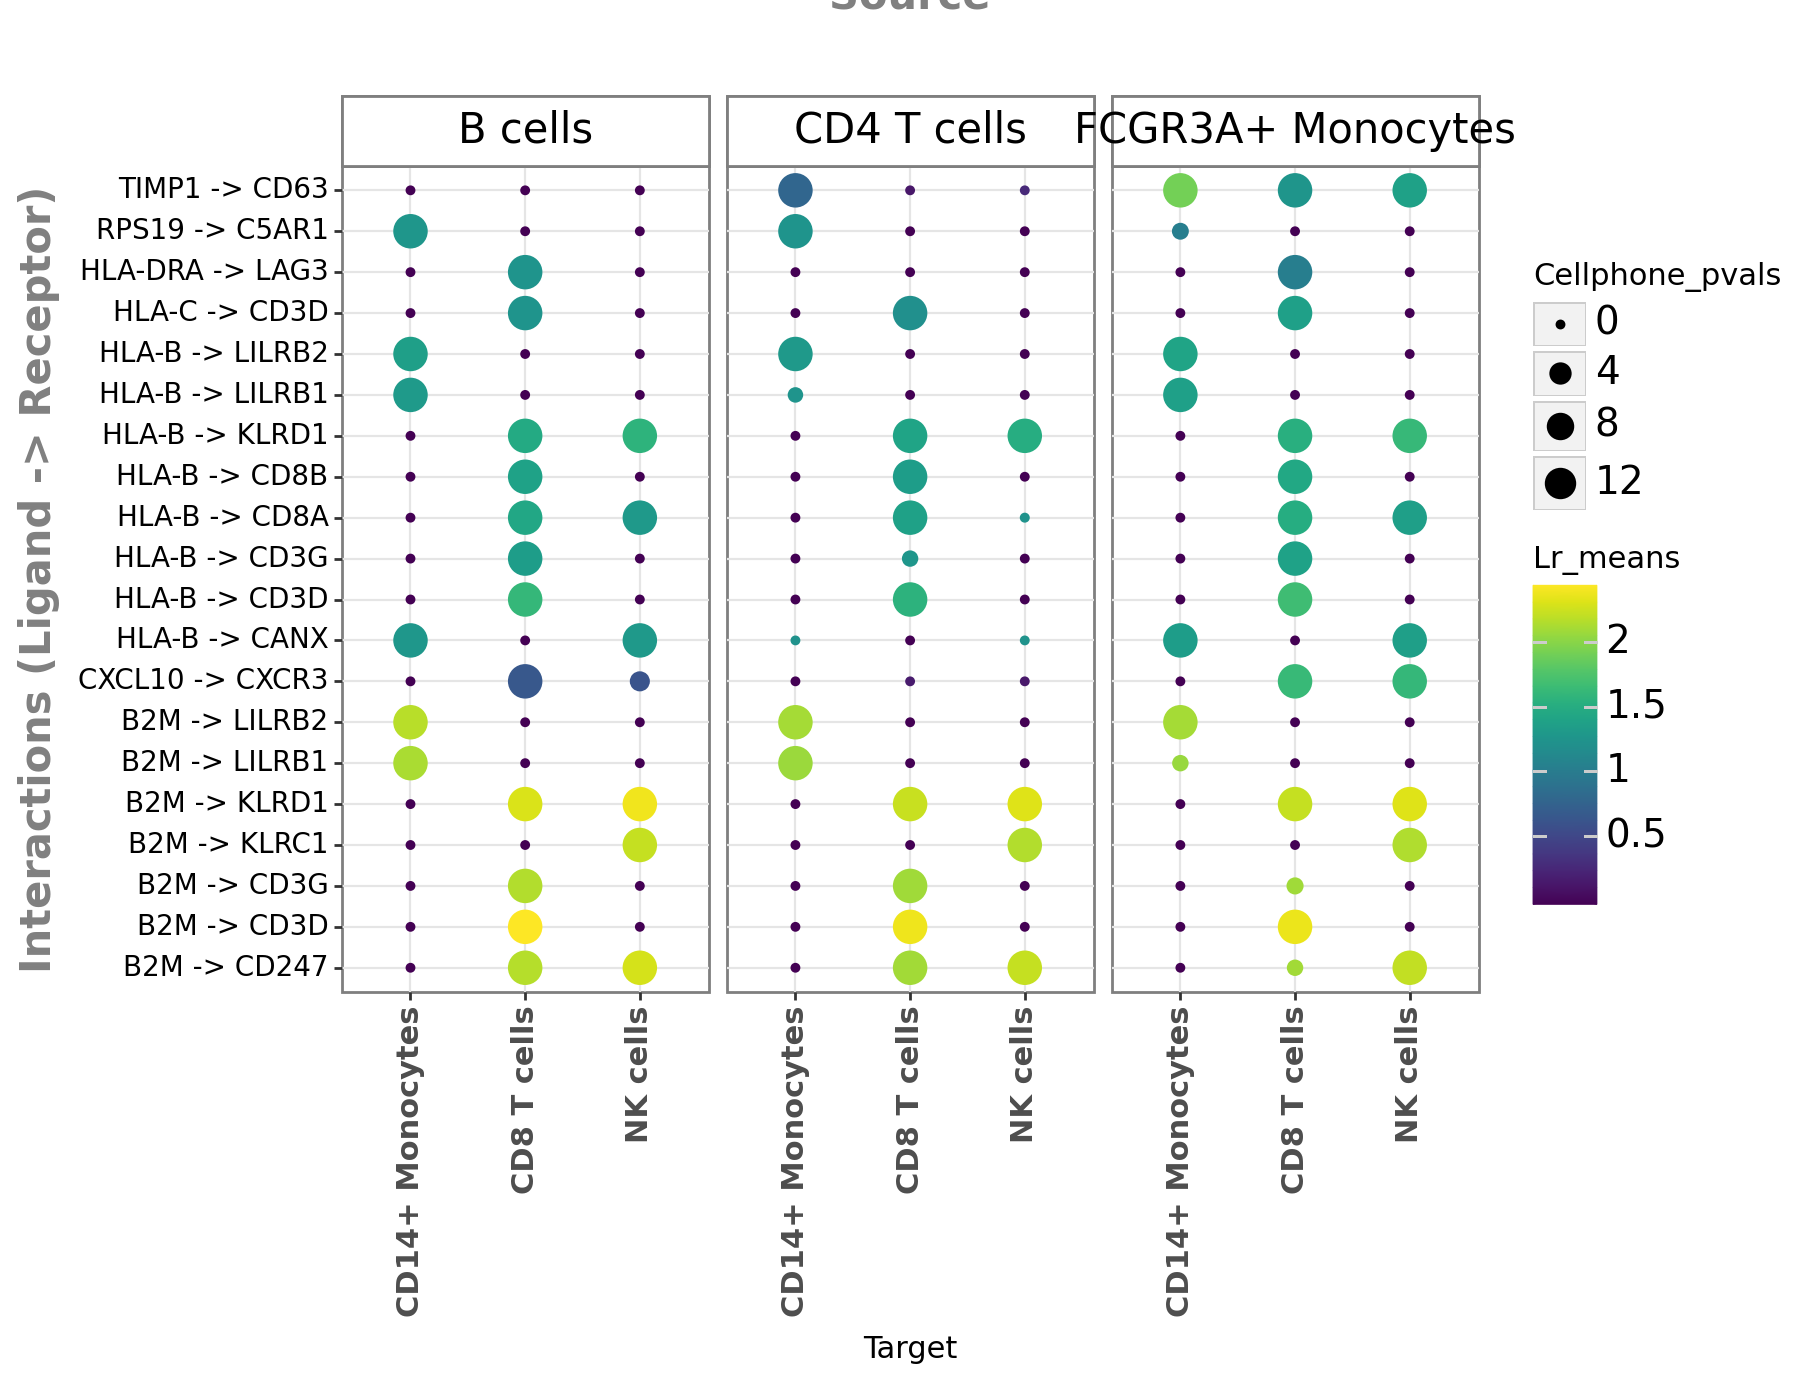

<Figure Size: (900 x 700)>

In [15]:
# Visual exploration

li.pl.dotplot(
    adata=adata_stim,
    colour="lr_means",
    size="cellphone_pvals",
    inverse_size=True,  # we inverse sign since we want small p-values to have large sizes
    # We choose only the cell types which we wish to plot
    source_labels=["CD4 T cells", "B cells", "FCGR3A+ Monocytes"],
    target_labels=["CD8 T cells", "CD14+ Monocytes", "NK cells"],
    # since cpdbv2 suggests using a filter to FPs
    # we can filter the interactions according to p-values <= 0.01
    filterby="cellphone_pvals",
    filter_lambda=lambda x: x <= 0.01,
    # as this type of methods tends to result in large numbers
    # of predictions, we can also further order according to
    # expression magnitude
    orderby="lr_means",
    orderby_ascending=False,  # we want to prioritize those with highest expression
    top_n=20,  # and we want to keep only the top 20 interactions
    figure_size=(9, 7),
    size_range=(1, 6),
)

Great, we get a number of interactions potentially linked to IFN-beta stimulation.

We can also see that both the magnitude (expression strength) and specificity of the interactions are cell-type dependent. For example, the potential binding of HLA-B binding to CD8A/B logically occurs only when the receiver cells are CD8 T cells.

## Generating a Ligand-Receptor consensus with LIANA

Given the reported limited agreement between the interactions inferred by different ligand-receptor methods, as a way to further increase the confidence in a potential interaction of interest, one could check if this interaction is predicted as relevant by more than a single method. In the same manner, one could also use multiple methods and focus on their consensus, or in other words focus on interactions consistently predicted as relevant. To this end, we will run the rank_aggregate method of liana [Dimitrov et al., 2022], which generates a probability distribution of highly ranked interactions across the methods.

为了进一步提高对感兴趣的潜在相互作用的信心，可以检查该相互作用是否被多个方法预测为相关。同样，可以使用多种方法并关注它们的共同结果

运行lian的rank_aggregate方法，该方法生成跨方法高排名相互作用的概率分布。

In [16]:
li.method.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...


In [17]:
from liana.method import rank_aggregate

In [18]:
rank_aggregate(
    adata_stim, groupby="cell_type", return_all_lrs=True, use_raw=False, verbose=True
)

Using `.X`!
Converting mat to CSR format
227 features of mat are empty, they will be removed.


/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/pandas/core/indexing.py:1728: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.46 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 12301 samples and 15474 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:05<00:00, 175.31it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [01:55<00:00,  8.67it/s]


In [19]:
adata_stim.uns["liana_res"].drop_duplicates(
    ["ligand_complex", "receptor_complex"]
).head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
1129,CD8 T cells,CD8 T cells,B2M,CD3D,2.562212,0.0,3.070147,1.070524,0.690730,0.062383,0.982125,0.123504,0.0,1.415831e-09,9.840017e-13
831,CD8 T cells,NK cells,B2M,KLRD1,2.511733,0.0,2.622731,1.541763,0.858930,0.080626,0.980689,0.110393,0.0,1.415831e-09,8.965786e-11
468,FCGR3A+ Monocytes,CD14+ Monocytes,TIMP1,CD63,1.877567,0.0,3.374182,1.478816,1.808744,0.123245,0.982935,0.136754,0.0,1.415831e-09,9.348292e-09
1513,CD8 T cells,FCGR3A+ Monocytes,B2M,LILRB2,2.402974,0.0,1.658766,1.466587,0.604138,0.078486,0.975838,0.063762,0.0,1.415831e-09,1.935320e-08
836,CD8 T cells,NK cells,B2M,CD247,2.414777,0.0,1.763377,1.156763,0.644404,0.074642,0.976548,0.041130,0.0,1.415831e-09,1.228218e-07


我们可以看到所有方法的评分函数的输出（如果有兴趣，可以参考上面的表格来确定哪个评分属于哪个方法）。更重要的是，我们还可以获得每个相互作用的`magnitude_rank`和`specificity_rank`，它们分别代表了共识相互作用的大小（表达强度）和特异性（在所有细胞类型对中）。

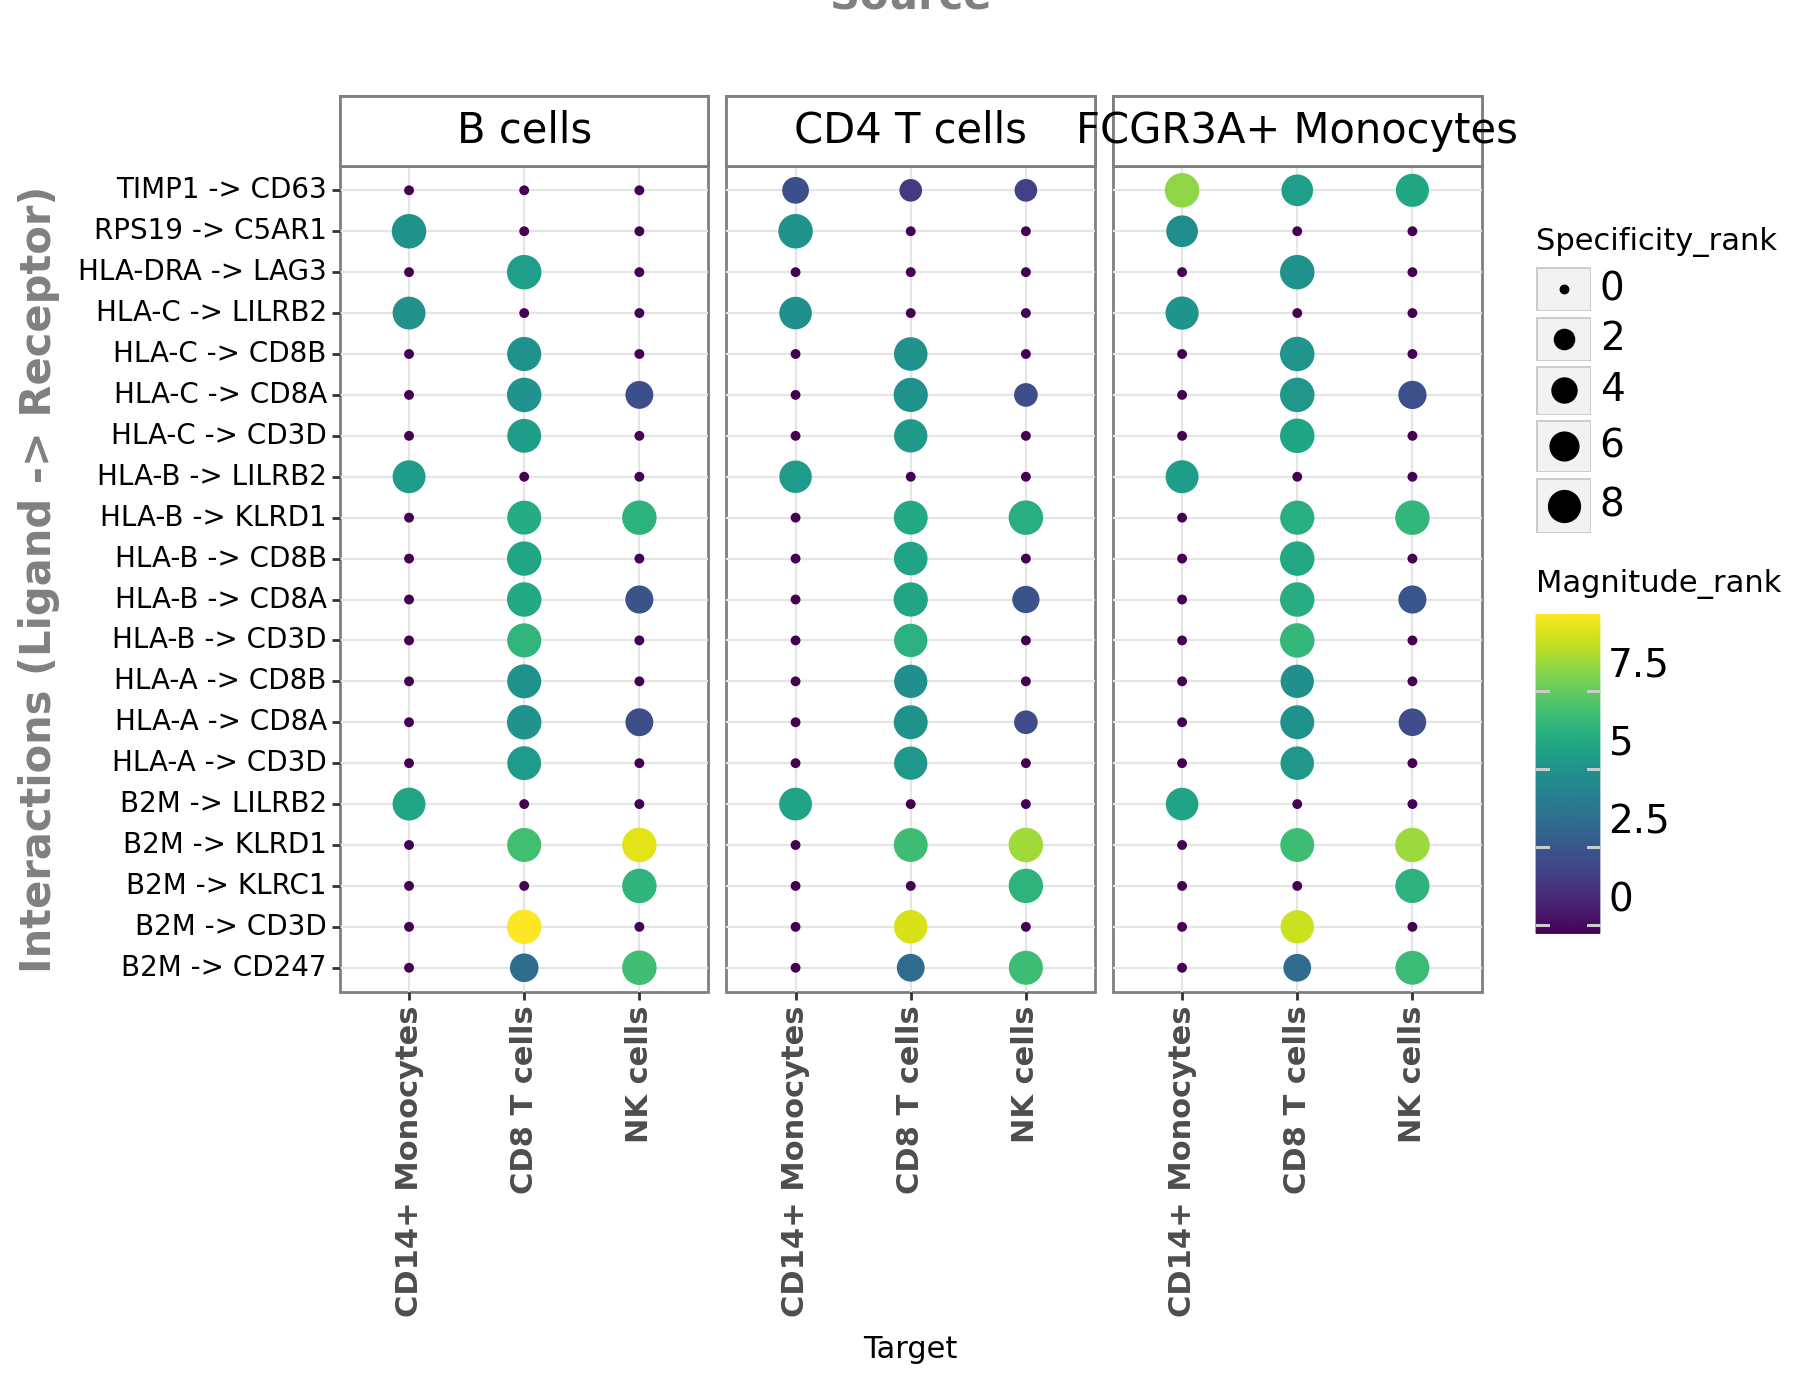

<Figure Size: (900 x 700)>

In [20]:
li.pl.dotplot(
    adata=adata_stim,
    colour="magnitude_rank",
    size="specificity_rank",
    inverse_colour=True,  # we inverse sign since we want small p-values to have large sizes
    inverse_size=True,
    # We choose only the cell types which we wish to plot
    source_labels=["CD4 T cells", "B cells", "FCGR3A+ Monocytes"],
    target_labels=["CD8 T cells", "CD14+ Monocytes", "NK cells"],
    # since the rank_aggregate can also be interpreted as a probability distribution
    # we can again filter them according to their specificity significance
    # yet here the interactions are filtered according to
    # how consistently highly-ranked is their specificity across the methods
    filterby="specificity_rank",
    filter_lambda=lambda x: x <= 0.05,
    # again, we can also further order according to magnitude
    orderby="magnitude_rank",
    orderby_ascending=True,  # prioritize those with lowest values
    top_n=20,  # and we want to keep only the top 20 interactions
    figure_size=(9, 7),
    size_range=(1, 6),
)

# Modelling differential intercellular signalling with NicheNet

NicheNet is another type of CCC method that considers the intracellular signaling effects triggered by intercellular interactions

In [21]:
%%R
# load NicheNet (NicheNet is only available on GitHub)
suppressPackageStartupMessages({
    library('nichenetr')
})

## Load NicheNet Prior-Knowledge

As mentioned above, NicheNet requires prior knowledge about ligand-receptor interactions and ligand-target links:

- a ligand_target_matrix - denotes the potential that a ligand might regulate the expression of a target genes. The weights in this matrix are based on prior knowledge and are required to prioritize possible ligand-receptor interactions and affected target genes.

- lr_network - the database of ligand-receptor interactions needed to define expressed ligands, receptors and their interactions.

In [22]:
%%R
# Increase timeout threshold
options(timeout=600)

# Load PK
# ligand_target_matrix <- readRDS(url("https://zenodo.org/record/7074291/files/ligand_target_matrix_nsga2r_final.rds"))
# lr_network <- readRDS(url("https://zenodo.org/record/7074291/files/lr_network_human_21122021.rds"))

ligand_target_matrix <- readRDS("/home/mowp/workspace/single_cell_analysis/single-cell-best-practics/ligand_target_matrix_nsga2r_final.rds")
lr_network <- readRDS("/home/mowp/workspace/single_cell_analysis/single-cell-best-practics/lr_network_human_21122021.rds")

### Define cell types of interest to be considered as senders/sources and receiver/targets of CCC interactions

In [23]:
sender_celltypes = ["CD4 T cells", "B cells", "FCGR3A+ Monocytes"]
receiver_celltypes = ["CD8 T cells"]

### Define a set of ligands that can potentially affect receiver cell types Helper function to obtain sufficiently expressed genes
Similarly to the ligand-receptor methods above, here we are only interested in the potential interactions that involve sufficiently expressed genes in each cell type. So, we will assume that e.g. 10% of the cells is a good threshold to reflect genes as expressed within a cell type.

In [24]:
from functools import reduce


def get_expressed_genes(adata, cell_type, expr_prop):
    # calculate proportions
    temp = adata[adata.obs["cell_type"] == cell_type, :]
    a = temp.X.getnnz(axis=0) / temp.X.shape[0]
    stats = (
        pd.DataFrame({"genes": temp.var_names, "props": a})
        .assign(cell_type=cell_type)
        .sort_values("genes")
    )

    # obtain expressed genes
    stats = stats[stats["props"] >= expr_prop]
    expressed_genes = stats["genes"].values

    return expressed_genes

In [25]:
sender_expressed = reduce(
    np.union1d,
    [
        get_expressed_genes(adata, cell_type=cell_type, expr_prop=0.1)
        for cell_type in sender_celltypes
    ],
)
receiver_expressed = reduce(
    np.union1d,
    [
        get_expressed_genes(adata, cell_type=cell_type, expr_prop=0.1)
        for cell_type in receiver_celltypes
    ],
)

In [26]:
sender_expressed

array(['AAED1', 'AAMP', 'ABHD3', ..., 'ZNRD1', 'ZRANB2', 'ZYX'],
      dtype=object)

In [27]:
receiver_expressed

array(['ABI3', 'ABRACL', 'ABT1', ..., 'ZNF706', 'ZNHIT1', 'ZNHIT3'],
      dtype=object)

In [28]:
%%R -i sender_expressed -i receiver_expressed
# get ligands and receptors in the resource
ligands <- lr_network %>% pull(from) %>% unique()
receptors <- lr_network %>% pull(to) %>% unique()

# only keep the intersect between the resource and the data
expressed_ligands <- intersect(ligands, sender_expressed)
expressed_receptors <- intersect(receptors, receiver_expressed)

# filter the network to only include ligands for which both the ligand and receptor are expressed
potential_ligands <- lr_network %>% 
  filter(from %in% expressed_ligands & to %in% expressed_receptors) %>%
  pull(from) %>% unique()

### Define a gene set of interest in receiver cell type(s)

In [29]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col="sample",
    groups_col="cell_type",
    min_prop=0.1,
    min_smpls=3,
    layer="counts",
)

In [30]:
# Normalize the pseudobulk counts

# Storing the raw counts
pdata.layers["counts"] = pdata.X.copy()

# Does PC1 captures a meaningful biological or technical fact?
pdata.obs["lib_size"] = pdata.X.sum(1)

# Normalize
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
# check how this looks like
pdata

AnnData object with n_obs × n_vars = 110 × 15701
    obs: 'condition', 'cell_type', 'patient', 'sample', 'psbulk_n_cells', 'psbulk_counts', 'lib_size'
    var: 'name', 'n_cells'
    uns: 'log1p'
    layers: 'psbulk_props', 'counts'

In [31]:
logFCs, pvals = dc.get_contrast(
    pdata,
    group_col="cell_type",
    condition_col="condition",
    condition="stim",
    reference="ctrl",
    method="t-test",
)

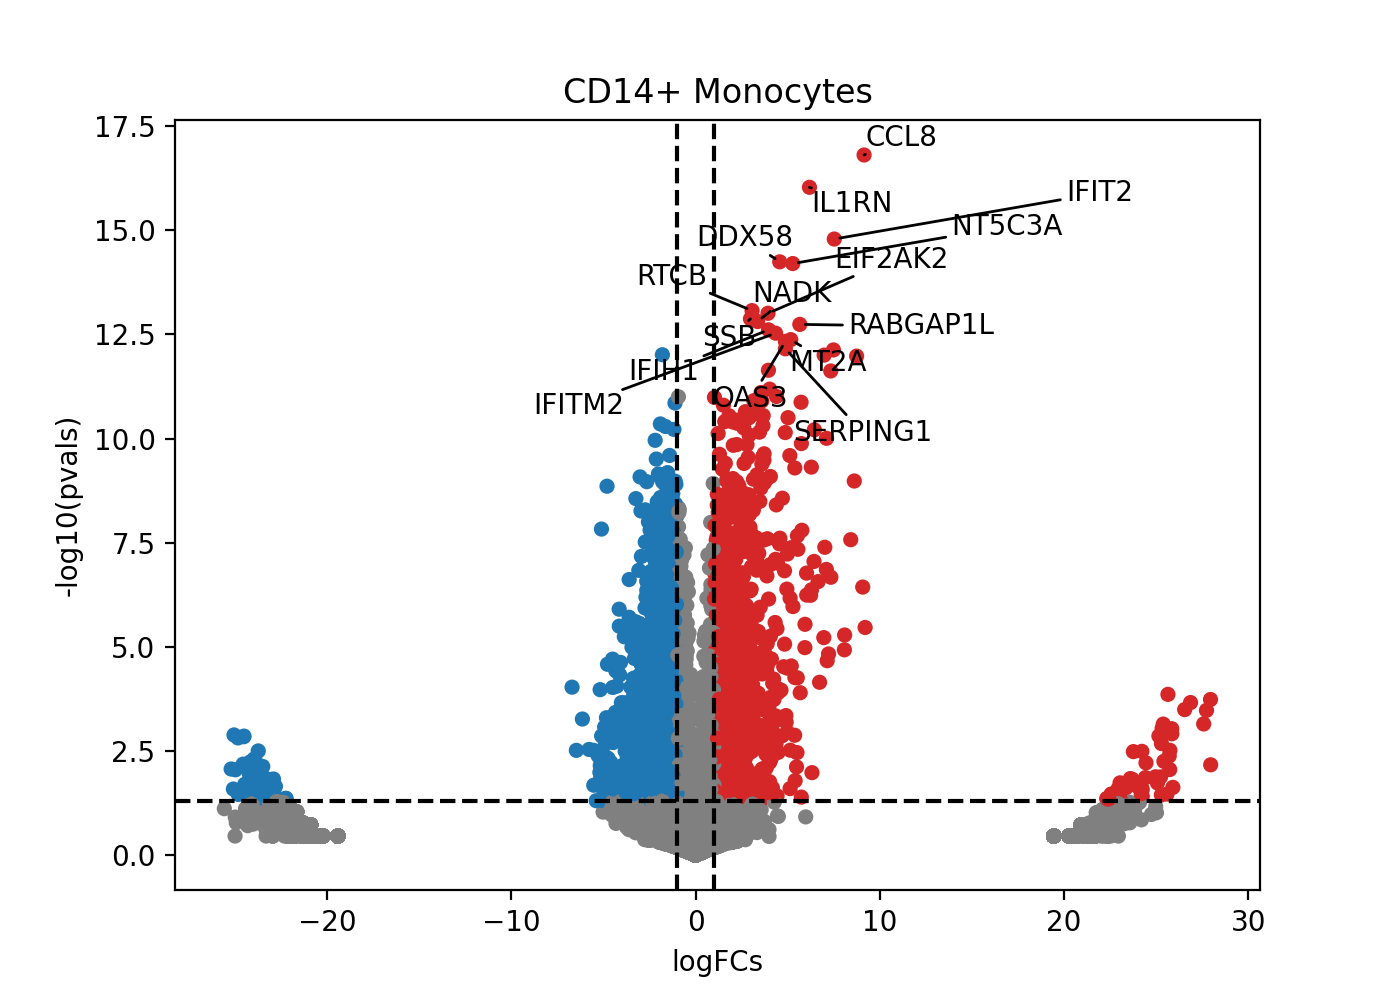

In [32]:
# Visualize those for e.g. CD14+ Monocytes
dc.plot_volcano(logFCs, pvals, "CD14+ Monocytes", top=15, sign_thr=0.05, lFCs_thr=1)

In [33]:
# format results
deg = dc.format_contrast_results(logFCs, pvals)
# only keep the receiver cell type(s)
deg = deg[np.isin(deg["contrast"], receiver_celltypes)]
deg.head()

,contrast,name,logFCs,pvals,adj_pvals
47103,CD8 T cells,IFIT3,6.394436,2.549009e-11,0.0
47104,CD8 T cells,SAMD9L,3.586875,5.000211e-11,0.0
47105,CD8 T cells,IFIT1,6.539666,7.268993e-11,0.0
47106,CD8 T cells,IFI6,5.609078,5.827544e-10,0.000002
47107,CD8 T cells,OAS1,5.570021,1.092566e-09,0.000003


In [34]:
# define background of sufficiently expressed genes
background_genes = deg["name"].values

# only keep significant and positive DE genes
deg = deg[(deg["pvals"] <= 0.05) & (deg["logFCs"] > 1)]
# get geneset of interest
geneset_oi = deg["name"].values

### NicheNet ligand activity estimation

To estimate ligand activity, NicheNet uses the regulatory potential of genes (based on prior knowledge) to predict which ligand best predicts the gene set of interest. Or in other words, it assesses whether the genes with high regulatory potential in regards to a specific ligand, are more likely to belong to the geneset of interest that we derive for the receiver cell type(s). Conceptually, this is not too dissimilar from standard Gene set enrichment and pathway analysis and NicheNet proposes different ways to estimate ligand activity, such as the area under the receiver operating characteristic curve, or Pearson correlation

In [35]:
%%R -i geneset_oi -i background_genes -o ligand_activities

ligand_activities <- predict_ligand_activities(geneset = geneset_oi, 
                                               background_expressed_genes = background_genes,
                                               ligand_target_matrix = ligand_target_matrix,
                                               potential_ligands = potential_ligands)

ligand_activities <- ligand_activities %>% 
  arrange(-aupr) %>% 
  mutate(rank = rank(desc(aupr)))

# show top10 ligand activities
head(ligand_activities, n=10)

# A tibble: 10 × 6
   test_ligand auroc   aupr aupr_corrected pearson  rank
   <chr>       <dbl>  <dbl>          <dbl>   <dbl> <dbl>
 1 PTPRC       0.791 0.0798         0.0650  0.148      1
 2 HLA-F       0.771 0.0674         0.0525  0.142      2
 3 HLA-A       0.767 0.0599         0.0450  0.136      3
 4 HLA-E       0.763 0.0546         0.0397  0.109      4
 5 HLA-B       0.759 0.0536         0.0387  0.125      5
 6 CD48        0.761 0.0503         0.0354  0.0958     6
 7 CCL5        0.758 0.0487         0.0338  0.0733     7
 8 ITGB2       0.731 0.0469         0.0320  0.116      8
 9 B2M         0.749 0.0450         0.0301  0.0927     9
10 HLA-DRA     0.749 0.0434         0.0286  0.0988    10


### Infer & Visualize top-predicted target genes for top ligands

In [36]:
%%R -o vis_ligand_target
top_ligands <- ligand_activities %>%
  top_n(15, aupr) %>% 
  arrange(-aupr) %>%
  pull(test_ligand) %>%
  unique()

# get regulatory potentials
ligand_target_potential <- map(top_ligands,
                               ~get_weighted_ligand_target_links(.x,
                                                                 geneset = geneset_oi,
                                                                 ligand_target_matrix = ligand_target_matrix,
                                                                 n = 500)
                              ) %>%
    bind_rows() %>% 
    drop_na()
    
# prep for visualization
active_ligand_target_links <- 
  prepare_ligand_target_visualization(ligand_target_df = ligand_target_potential, 
                                      ligand_target_matrix = ligand_target_matrix)

# order ligands & targets
order_ligands <- intersect(top_ligands,
                           colnames(active_ligand_target_links)) %>% rev() %>% make.names()
order_targets <- ligand_target_potential$target %>%
  unique() %>% 
  intersect(rownames(active_ligand_target_links)) %>%
  make.names()
rownames(active_ligand_target_links) <- rownames(active_ligand_target_links) %>%
  make.names() # make.names() for heatmap visualization of genes like H2-T23
colnames(active_ligand_target_links) <- colnames(active_ligand_target_links) %>%
  make.names() # make.names() for heatmap visualization of genes like H2-T23

vis_ligand_target <- active_ligand_target_links[order_targets, order_ligands] %>%
  t()
    
# convert to dataframe, and then it's returned to py
vis_ligand_target <- vis_ligand_target %>%
    as.data.frame() %>%
    rownames_to_column("ligand") %>%
    as_tibble()

In [37]:
# convert dot to underscore and set ligand as index
vis_ligand_target["ligand"] = vis_ligand_target["ligand"].replace("\.", "_", regex=True)
vis_ligand_target.set_index("ligand", inplace=True)
# keep only columns where at least one gene has a regulatory potential >= 0.05
vis_ligand_target = vis_ligand_target.loc[
    :, vis_ligand_target[vis_ligand_target >= 0.05].any()
]
vis_ligand_target.head()

,AIM2,CCL2,CCL3,CD69,CXCL10,GBP1,GBP4,IFIH1,IFIT2,IFITM1,...,OAS3,CD38,GBP2,EHD4,HAVCR2,IL18RAP,PARP8,PIM2,SPCS3,ZBP1
ligand,,,,,,,,,,,,,,,,,,,,,
HLA_DQB1,0.000000,0.009779,0.000000,0.007720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
IL15,0.149317,0.133514,0.191512,0.202307,0.085065,0.206406,0.061923,0.010933,0.078044,0.088810,...,0.073824,0.120233,0.060531,0.074099,0.07433,0.099282,0.085015,0.133337,0.079955,0.075642
CXCL11,0.000000,0.009682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
ICAM1,0.008415,0.019244,0.070233,0.011545,0.013325,0.006771,0.007813,0.008649,0.010065,0.007597,...,0.006798,0.008493,0.008395,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
CXCL10,0.000000,0.014246,0.000000,0.008737,0.010101,0.000000,0.000000,0.000000,0.006990,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


### Visualize top ligands & regulatory targets

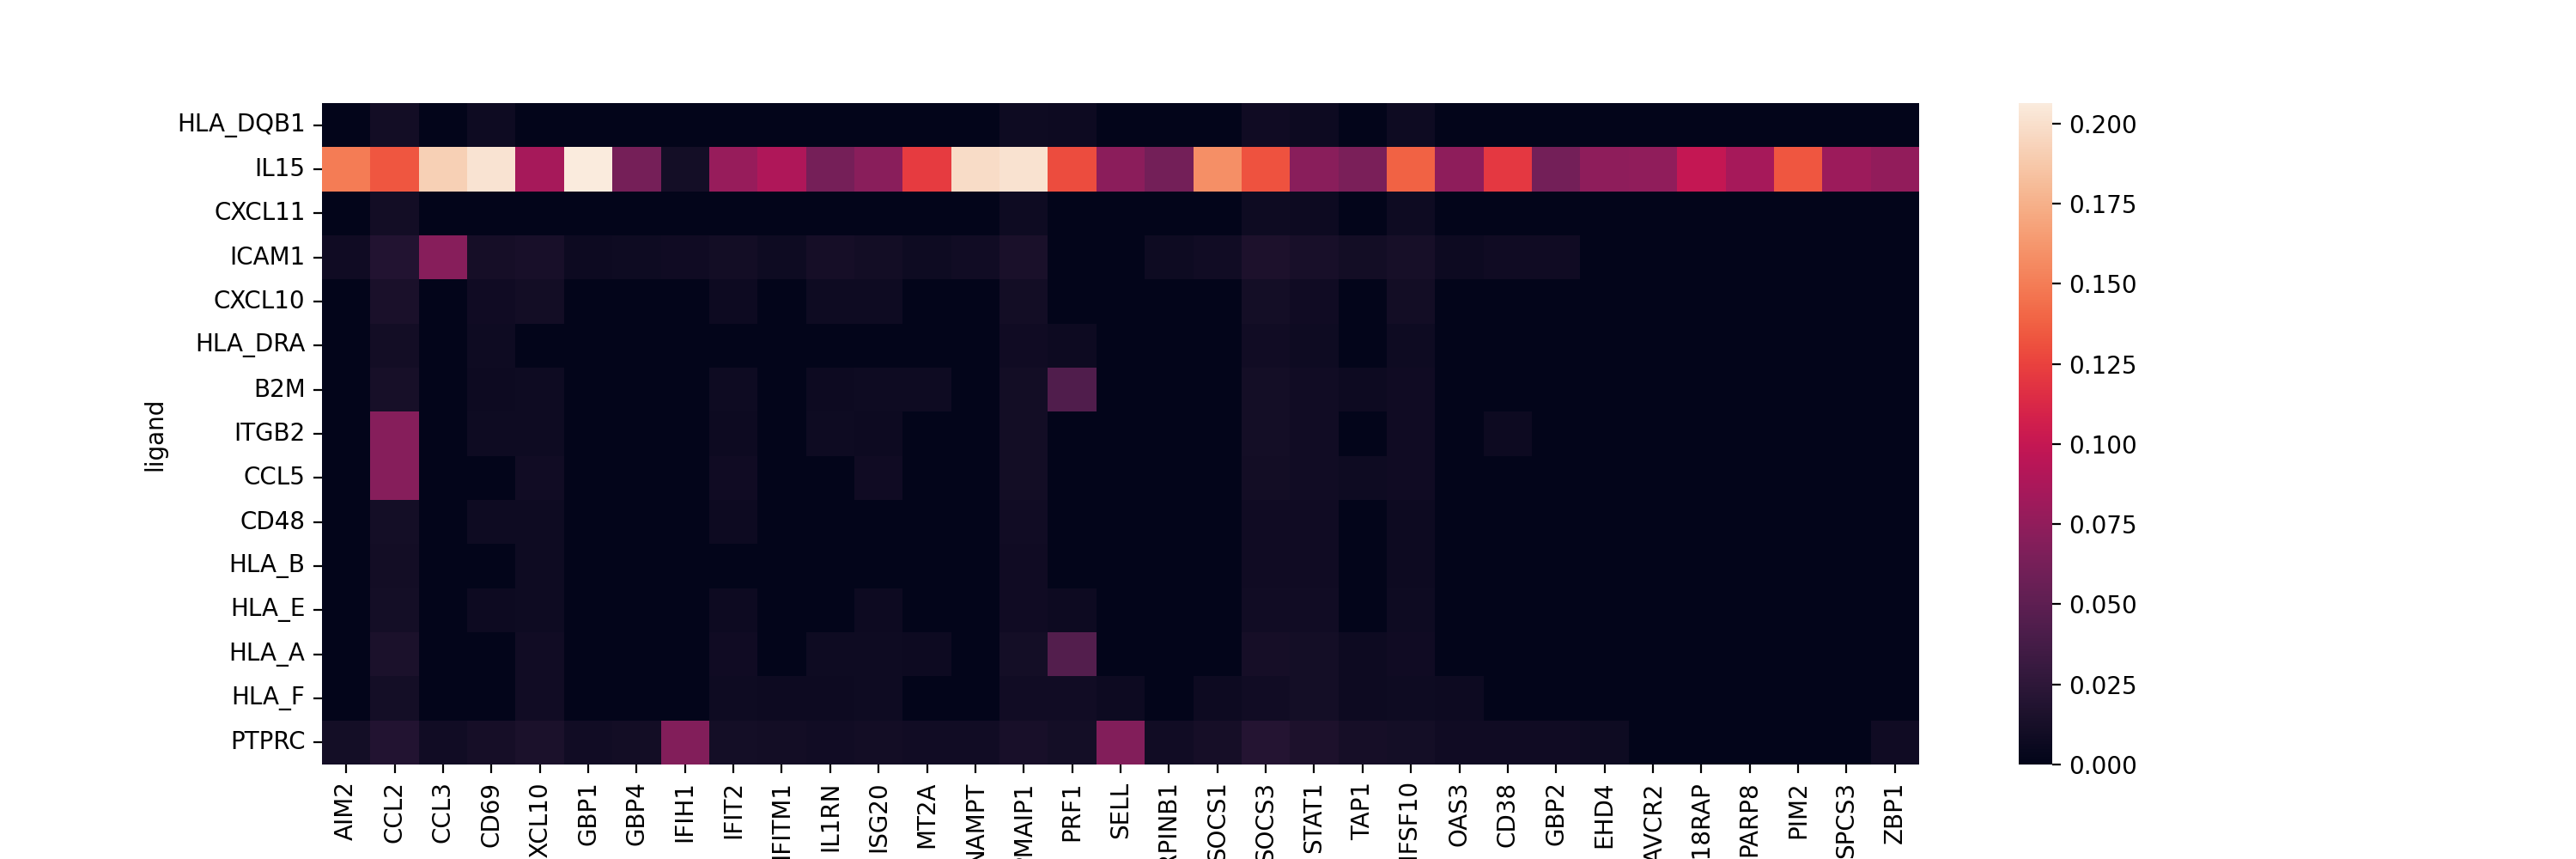

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.heatmap(vis_ligand_target, xticklabels=True, ax=ax)
plt.show()

## Combining NicheNet output with ligand-receptor inference

In [39]:
ligand_oi = ligand_activities.head(3)["test_ligand"].values

In [40]:
ligand_oi


array(['PTPRC', 'HLA-F', 'HLA-A'], dtype=object)

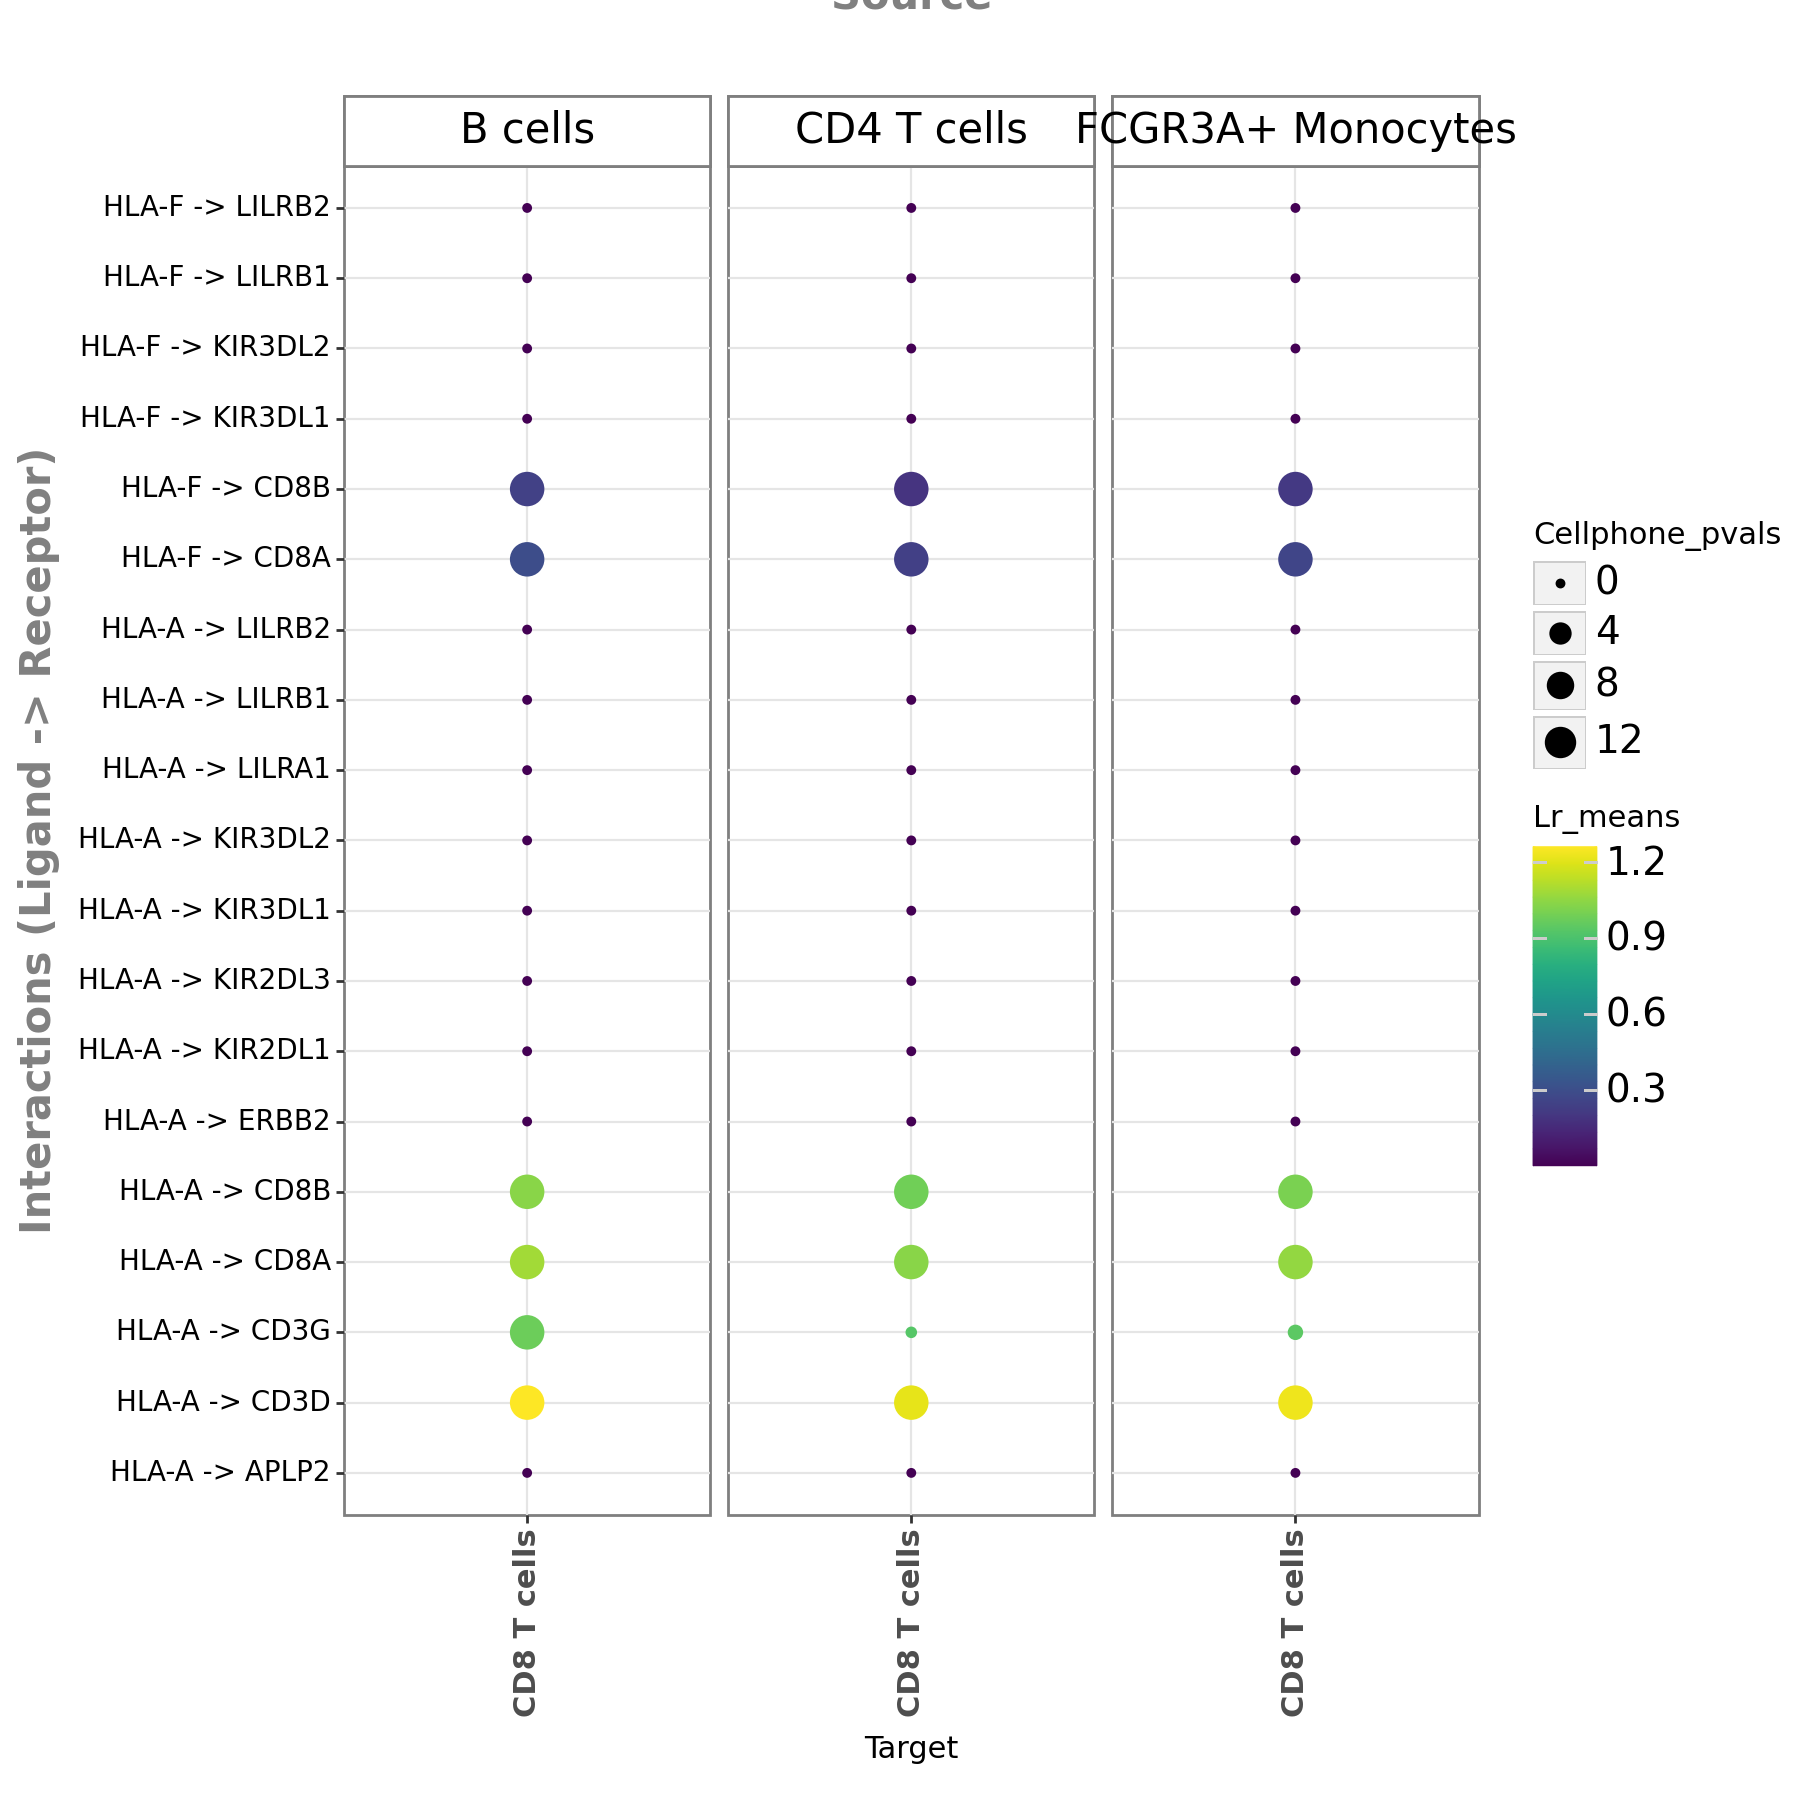

<Figure Size: (900 x 900)>

In [41]:
li.pl.dotplot(
    adata=adata_stim,
    colour="lr_means",
    size="cellphone_pvals",
    inverse_size=True,  # we inverse sign since we want small p-values to have large sizes
    # We choose only the cell types which we wish to plot
    source_labels=sender_celltypes,
    target_labels=receiver_celltypes,
    # keep only those ligands
    filterby="ligand_complex",
    filter_lambda=lambda x: np.isin(x, ligand_oi),
    # as this type of methods tends to result in large numbers
    # of predictions, we can also further order according to
    # expression magnitude
    orderby="magnitude_rank",
    orderby_ascending=False,  # we want to prioritize those with highest expression
    top_n=25,  # and we want to keep only the top 25 interactions
    figure_size=(9, 9),
    size_range=(1, 6),
)

- 什么情况下可以使用NicheNet进行细胞通讯分析？
  
  NicheNet 可以用于研究配体如何影响假定相邻或者相互作用的细胞群中的基因表达情况，并根据其作用对最重要的配体进行优先排序。需要提供不同条件或者状态下，接受信号的细胞群（receiver cell）中的差异基因列表，通常认为这些基因的差异表达是发送信号细胞群中的配体导致的 。因此，可以是同一类型细胞在不同条件下的差异表达基因，也可以是两种细胞类型之间的差异表达基因，例如，如果它们是祖细胞和分化细胞类型，其中分化受微环境的影响。

 

- 如果没有相应的条件或者状态来对细胞群进行区分， 只有稳态数据，是否可以采用NicheNet来进行分析？
  
  如果只对稳态条件下的配体 - 受体相互作用感兴趣（并且只有稳态条件数据），可以采用CellphoneDB 等其他一些工具来实现， 不建议将NicheNet应用于稳态数据，主要是由于不存在一组明确地受细胞间通讯过程影响的基因，从而可能导致错误地将配体与一些细胞内在基因进行关联。